In [ ]:
!pip install ctgan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, chi2_contingency
from ctgan import CTGAN
import time

In [ ]:
df = pd.read_parquet(r"/content/dataset_modelo.parquet")

In [ ]:
df.columns

Index(['churn', 'age', 'credit_score', 'withdrawal', 'purchases_partners',
       'purchases', 'cc_taken', 'cc_recommended', 'cc_disliked', 'cc_liked',
       'cc_application_begin', 'app_downloaded', 'web_user', 'ios_user',
       'android_user', 'registered_phones', 'waiting_4_loan', 'cancelled_loan',
       'received_loan', 'rejected_loan', 'left_for_two_month_plus',
       'left_for_one_month', 'is_referred', 'housing_o', 'housing_r',
       'payment_type_is_NA', 'payment_type_encoded'],
      dtype='object')

In [ ]:
df_original = df.copy()

In [ ]:
#convertir columnas (binarias o categóricas) a tipo str
def filtrar_columnas_binarias(df):
    """
    Filtra y devuelve una lista de los nombres de las columnas
    que solo contienen los valores 0 y 1 (excluyendo NaNs).
    """
    columnas_binarias = []

    for col in df.columns:
        # Extraer solo los valores únicos no nulos
        valores_unicos = df[col].dropna().unique()

        # Verificar si tiene 1 o 2 valores únicos no nulos
        if len(valores_unicos) <= 2:

            # 2. Verificar si todos esos valores son 0, 1, o ambos.
            # Convertimos a string para manejar enteros (0, 1) y floats (0.0, 1.0)
            valores_str = [str(int(v)) for v in valores_unicos if np.isclose(v, 0.0) or np.isclose(v, 1.0)]

            # Si el número de valores únicos es igual al número de valores que son 0 o 1, es binaria.
            if len(valores_unicos) == len(valores_str):
                columnas_binarias.append(col)

    return columnas_binarias

# Obtener la lista de columnas binarias
columnas_binarias = filtrar_columnas_binarias(df)

print("--- Columnas que contienen solo 0 y 1")
print(columnas_binarias)

df_original[columnas_binarias] = df_original[columnas_binarias].astype(str)

# columna categorica (a la cual aplicamos label encoding)
df_original["payment_type_encoded"] = df_original["payment_type_encoded"].astype("category")


--- Columnas que contienen solo 0 y 1
['churn', 'app_downloaded', 'web_user', 'ios_user', 'android_user', 'waiting_4_loan', 'cancelled_loan', 'received_loan', 'rejected_loan', 'left_for_two_month_plus', 'left_for_one_month', 'is_referred', 'housing_o', 'housing_r', 'payment_type_is_NA']


ROC_AUC indica el dataset sintético que mejor soporta el entrenamiento de la Red Neuronal.
|                   |   Accuracy |   F1_Score |   ROC_AUC |
|:------------------|-----------:|-----------:|----------:|
| Real_Train        |   0.667003 |   0.627823 |  0.722896 |
| synthetic_df_e450 |   0.630632 |   0.6089   |  0.678418 |
| synthetic_df_e600 |   0.610224 |   0.636244 |  0.675475 |
| synthetic_df_e400 |   0.62255  |   0.618152 |  0.6731   |
| synthetic_df_e350 |   0.605779 |   0.64287  |  0.669275 |
| synthetic_df_e250 |   0.583956 |   0.294621 |  0.656316 |
| synthetic_df_e200 |   0.612245 |   0.564556 |  0.655266 |
| synthetic_df_e300 |   0.590422 |   0.364776 |  0.653996 |
| synthetic_df_e150 |   0.555264 |   0.600182 |  0.602978 |
| synthetic_df_e100 |   0.474843 |   0.472926 |  0.474599 |

|                   |   Accuracy |   F1_Score |   ROC_AUC |
|:------------------|-----------:|-----------:|----------:|
| Real_Train        |   0.667003 |   0.627823 |  0.722896 |
| synthetic_df_e900 |   0.640533 |   0.651108 |  0.70109  |
| synthetic_df_e550 |   0.643362 |   0.624228 |  0.698089 |
| synthetic_df_e650 |   0.645585 |   0.603705 |  0.695419 |
| synthetic_df_e500 |   0.633259 |   0.628607 |  0.683691 |



In [ ]:
# Valores de epochs a probar
EPOCHS_VALUES = [ 500, 550, 650, 900]#[100, 150, 200, 250, 300, 350, 400, 450, 600

n_samples = df.shape[0]

# Diccionario para almacenar los DataFrames sintéticos generados
synthetic_datasets = {}

categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("🤖 Iniciando la generación de datasets sintéticos con CTGAN para diferentes epochs...\n")

for epochs in EPOCHS_VALUES:
    start_time = time.time()
    key_name = f'synthetic_df_e{epochs}'

    print(f"⚙️ Procesando: {key_name} (EPOCHS={epochs})...")

    ctgan = CTGAN(epochs=epochs, verbose=True)

    ctgan.fit(df, discrete_columns=categorical_cols)

    # Generar el dataset sintético
    df_synthetic_ctgan = ctgan.sample(n_samples)

    # Almacenar el DataFrame generado
    synthetic_datasets[key_name] = df_synthetic_ctgan

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"✅ Generación completada para {key_name} en {elapsed_time:.2f} segundos.")
    print("-" * 60)


print(f"Todos los DataFrames están en el diccionario 'synthetic_datasets'.")

🤖 Iniciando la generación de datasets sintéticos con CTGAN para diferentes epochs...

⚙️ Procesando: synthetic_df_e500 (EPOCHS=500)...


Gen. (0.13) | Discrim. (-0.49): 100%|██████████| 500/500 [15:54<00:00,  1.91s/it]


✅ Generación completada para synthetic_df_e500 en 1023.66 segundos.
------------------------------------------------------------
⚙️ Procesando: synthetic_df_e550 (EPOCHS=550)...


Gen. (0.11) | Discrim. (-0.05): 100%|██████████| 550/550 [17:08<00:00,  1.87s/it]


✅ Generación completada para synthetic_df_e550 en 1077.61 segundos.
------------------------------------------------------------
⚙️ Procesando: synthetic_df_e650 (EPOCHS=650)...


Gen. (-0.29) | Discrim. (-0.22): 100%|██████████| 650/650 [20:16<00:00,  1.87s/it]


✅ Generación completada para synthetic_df_e650 en 1265.91 segundos.
------------------------------------------------------------
⚙️ Procesando: synthetic_df_e900 (EPOCHS=900)...


Gen. (0.24) | Discrim. (-1.08): 100%|██████████| 900/900 [27:58<00:00,  1.87s/it]


✅ Generación completada para synthetic_df_e900 en 1727.97 segundos.
------------------------------------------------------------
Todos los DataFrames están en el diccionario 'synthetic_datasets'.


revertir tipos de datos

In [ ]:
print("Iniciando la reversión de tipos de datos en todos los DataFrames sintéticos...")

# Iterar sobre cada DataFrame en el diccionario
for key, df_synthetic in synthetic_datasets.items():
    print(f"  Procesando {key}...")

    # Iterar sobre las columnas que deben ser numéricas
    for col in categorical_cols:
        if col in df_synthetic.columns:
            try:
                df_synthetic[col] = pd.to_numeric(df_synthetic[col], errors='coerce').astype('Int64')

            except Exception as e:
                try:
                     df_synthetic[col] = pd.to_numeric(df_synthetic[col], errors='coerce').astype(float)
                except:
                     print(f"    Advertencia: No se pudo revertir la columna {col} a numérico en {key}. Dejando como object.")

Iniciando la reversión de tipos de datos en todos los DataFrames sintéticos...
  Procesando synthetic_df_e500...
  Procesando synthetic_df_e550...
  Procesando synthetic_df_e650...
  Procesando synthetic_df_e900...


In [ ]:
# Iterar sobre las columnas que deben ser numéricas en el DF Original
for col in categorical_cols:
    if col in df_original.columns:
        try:
            df_original[col] = pd.to_numeric(df_original[col], errors='coerce').astype('Int64')

        except Exception as e:
            try:
                 df_original[col] = pd.to_numeric(df_original[col], errors='coerce').astype(float)
            except:
                 print(f"    Advertencia: No se pudo revertir la columna {col} a numérico en el DF original. Dejando como object.")

Coherencia univariada( por variable )

In [ ]:
from scipy.stats import ks_2samp

def calcular_ks_coherencia(df_original, synthetic_datasets, continuous_cols):
    """
    Calcula el p-valor promedio del KS-Test para las columnas continuas,
    comparando cada dataset sintético con el original.
    """
    ks_results = {}

    for key, df_synthetic in synthetic_datasets.items():
        p_values = []

        for col in continuous_cols:
            if col in df_synthetic.columns and col in df_original.columns:
                data_real = df_original[col].dropna().values
                data_synthetic = df_synthetic[col].dropna().values

                if len(data_real) > 0 and len(data_synthetic) > 0:
                    _, p_value = ks_2samp(data_real, data_synthetic)
                    p_values.append(p_value)

        if p_values:
            avg_p_value = np.mean(p_values)
            ks_results[key] = f'{avg_p_value:.4f}'
        else:
            ks_results[key] = 'N/A'

    return ks_results

all_cols = set(df.columns.tolist())
continuous_cols = list(all_cols - set(categorical_cols))

coherence_scores = calcular_ks_coherencia(df, synthetic_datasets, continuous_cols)

print("--- P-valor promedio del KS-Test por Dataset Sintético ---")
print("  (Cuanto más cerca de 1.0, mejor. > 0.05 es generalmente aceptable)\n")
for key, score in coherence_scores.items():
    print(f"  {key}: {score}")

--- P-valor promedio del KS-Test por Dataset Sintético ---
  (Cuanto más cerca de 1.0, mejor. > 0.05 es generalmente aceptable)

  synthetic_df_e500: 0.3201
  synthetic_df_e550: 0.3582
  synthetic_df_e650: 0.3656
  synthetic_df_e900: 0.3888


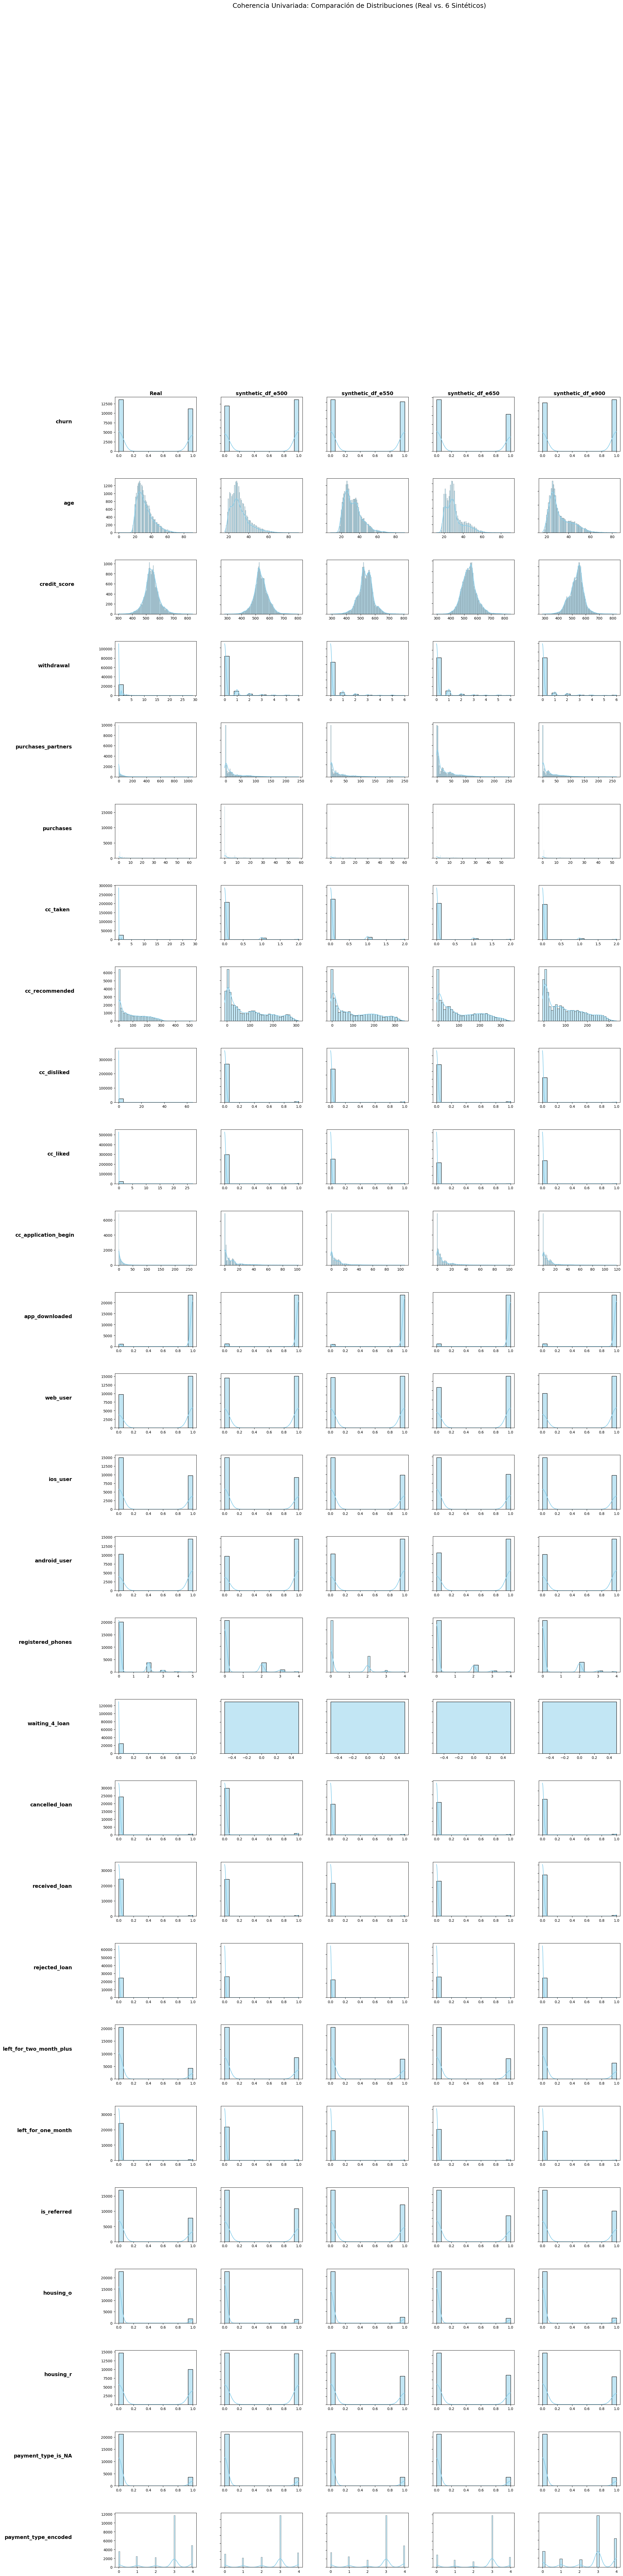

In [ ]:
def visualizar_coherencia_univariada(df_original, synthetic_datasets, categorical_cols):
    """
    Genera subplots de 1 fila por columna y 7 columnas (Real + 6 Sintéticos)
    para comparar las distribuciones.
    """

    # Consolidar todos los DFs para facilitar la iteración
    all_dfs = {'Real': df_original}
    all_dfs.update(synthetic_datasets)

    # Obtener la lista de todas las columnas (numéricas y categóricas)
    column_list = df_original.columns.tolist()

    n_rows = len(column_list)
    n_cols = len(all_dfs) # 7 (Real + 6 Sintéticos)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    plt.subplots_adjust(hspace=0.5, wspace=0.3)

    for i, col in enumerate(column_list):
        for j, (name, df_data) in enumerate(all_dfs.items()):
            ax = axes[i, j]

            # Título de la columna (Dataset)
            if i == 0:
                ax.set_title(name, fontsize=14, fontweight='bold')

            # Título de la fila (Variable)
            if j == 0:
                ax.set_ylabel(col, fontsize=14, fontweight='bold', rotation=0, labelpad=80, ha='right')

            if col in categorical_cols:
                # Variable Categórica: Usar Gráfico de Barras de Conteo
                sns.countplot(x=col, data=df_data, ax=ax, palette='viridis', order=df_data[col].value_counts().index)
                ax.set_xlabel('')
                ax.tick_params(axis='x', rotation=45)
            else:
                # Variable Numérica/Continua: Usar Histograma con KDE
                sns.histplot(df_data[col], kde=True, ax=ax, color='skyblue', edgecolor='black')
                ax.set_xlabel('')

            # Limpiar etiquetas del eje Y, excepto en la primera columna
            if j > 0:
                 ax.set_yticklabels([])
                 ax.set_ylabel('')

    plt.suptitle("Coherencia Univariada: Comparación de Distribuciones (Real vs. 6 Sintéticos)", fontsize=18, y=1.02)
    plt.show()

# Ejecutar la visualización
visualizar_coherencia_univariada(df, synthetic_datasets, categorical_cols)

Coherencia multivariada (relaciones entre variables)

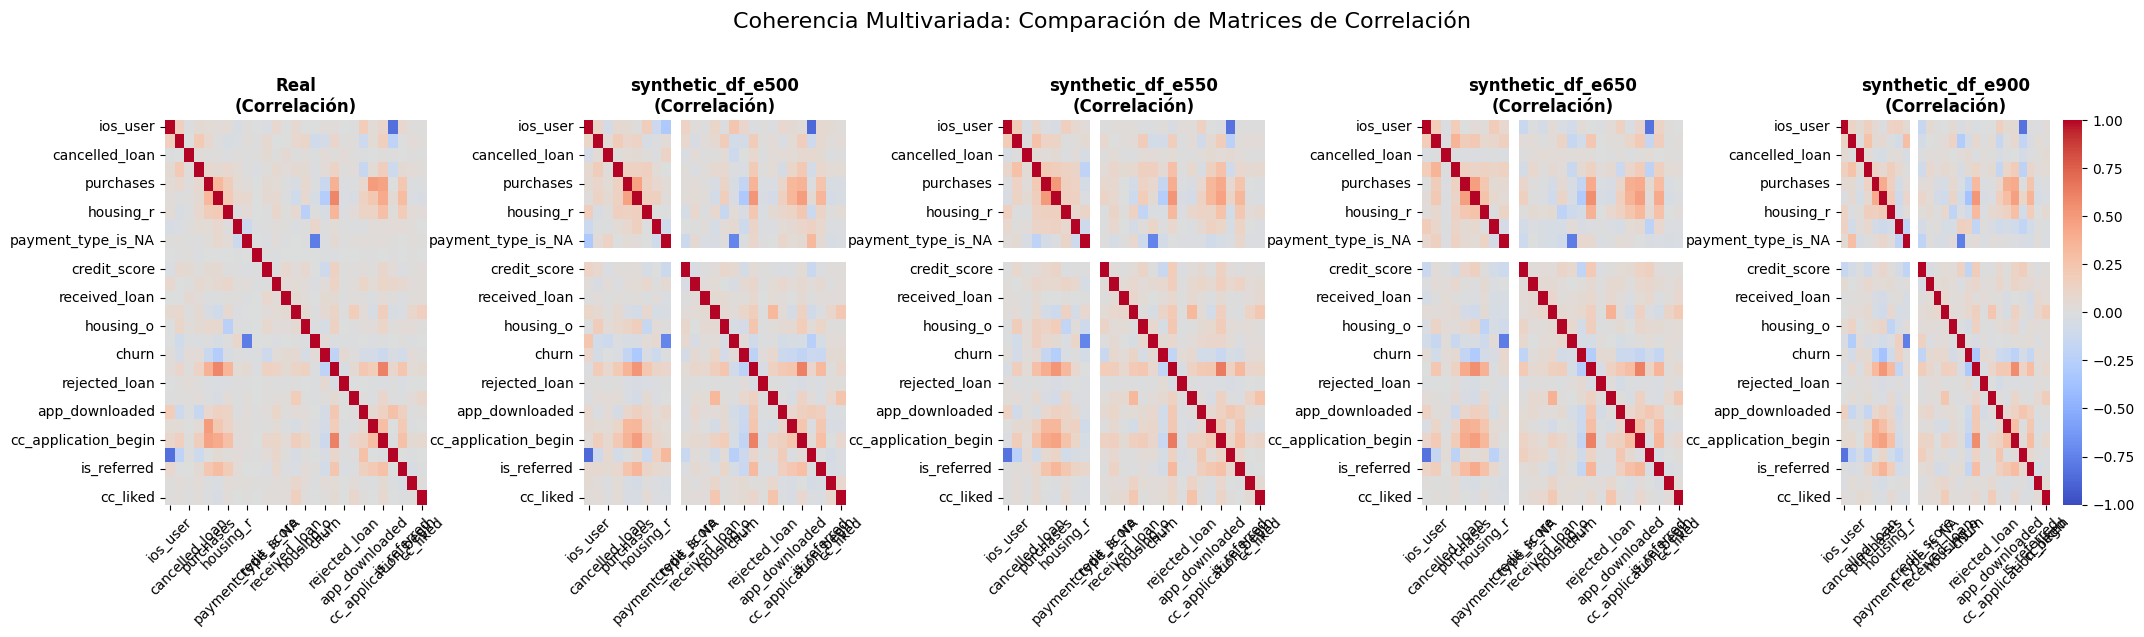

In [ ]:
def visualizar_matrices_correlacion(df_original, synthetic_datasets, categorical_cols):
    """
    Genera mapas de calor (heatmaps) de las matrices de correlación para
    comparar las relaciones entre variables numéricas del Real vs. Sintéticos.
    """

    # 1. Preparar los DataFrames
    all_dfs = {'Real': df_original}
    all_dfs.update(synthetic_datasets)

    # 2. Identificar Columnas Numéricas (Continuas)
    all_cols = set(df_original.columns.tolist())
    # Columnas numéricas = Todas las columnas - Columnas categóricas
    numerical_cols = list(all_cols - set(categorical_cols))

    # Verificar que hay columnas numéricas para correlacionar
    if not numerical_cols:
        print("ADVERTENCIA: No se encontraron columnas numéricas (continuas) para calcular la correlación.")
        return

    # 3. Configuración de Subplots
    n_cols = len(all_dfs) # 7 (Real + 6 Sintéticos)
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 5))
    plt.subplots_adjust(wspace=0.6)

    # El valor absoluto más alto de correlación en el dataset real,
    # usado para normalizar el colorbar en todos los heatmaps.
    vmax_global = 0
    try:
        real_corr_matrix = df_original[numerical_cols].corr()
        vmax_global = np.max(np.abs(real_corr_matrix.values))
    except Exception as e:
        print(f"Error al calcular la matriz de correlación real: {e}")
        return

    # 4. Generación de Heatmaps
    for j, (name, df_data) in enumerate(all_dfs.items()):
        ax = axes[j]

        # Calcular la matriz de correlación solo con las columnas numéricas
        corr_matrix = df_data[numerical_cols].corr()

        # Generar el mapa de calor
        sns.heatmap(
            corr_matrix,
            vmin=-vmax_global, # Escala de color basada en el máximo del dataset real
            vmax=vmax_global,
            center=0,
            annot=False, # Ponemos False para evitar saturar el gráfico, pero puedes poner True si son pocas columnas
            cmap='coolwarm',
            fmt=".2f",
            ax=ax,
            cbar=j == n_cols - 1 # Mostrar el colorbar solo en el último gráfico
        )

        ax.set_title(f"{name}\n(Correlación)", fontsize=12, fontweight='bold')
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=0)

    plt.suptitle("Coherencia Multivariada: Comparación de Matrices de Correlación", fontsize=16, y=1.1)
    plt.show()

visualizar_matrices_correlacion(df, synthetic_datasets, categorical_cols)

TSTR

In [ ]:
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from copy import deepcopy

nombre_archivo_modelo = 'mlp_datos_reales.joblib'
mlp_base_pipeline = joblib.load(nombre_archivo_modelo)
print(f"✅ Pipeline base MLP cargado: {nombre_archivo_modelo}")

# Definición de la columna objetivo y las predictoras (X)
TARGET_COL = 'churn'
FEATURES = [col for col in df.columns if col != TARGET_COL]

df_train_real, df_test_real = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df[TARGET_COL]
)

# Definir el conjunto de prueba REAL
X_test_real = df_test_real[FEATURES].fillna(0)
Y_test_real = df_test_real[TARGET_COL].astype(int)

tstr_results = {}
tstr_datasets = {'Real_Train': df_train_real}
tstr_datasets.update(synthetic_datasets) # Asumiendo que 'synthetic_datasets' está disponible

# El valor 'Int64' puede causar problemas (Código para corregir tipos)
for name in tstr_datasets:
    for col in tstr_datasets[name].columns:
        if tstr_datasets[name][col].dtype.name == 'Int64':
             tstr_datasets[name][col] = tstr_datasets[name][col].astype('float64')


print("📈 Iniciando la prueba de Utilidad Predictiva (TSTR) con MLP Pipeline...")

for name, df_train in tstr_datasets.items():
    print(f"\n⚙️ Entrenando modelo con dataset: {name}...")

    # Definir los datos de entrenamiento (X_train, Y_train)
    X_train = df_train[FEATURES].fillna(0)
    Y_train = df_train[TARGET_COL].astype(int)

    model = deepcopy(mlp_base_pipeline)

    model.fit(X_train, Y_train)

    Y_pred = model.predict(X_test_real)
    Y_proba = model.predict_proba(X_test_real)[:, 1]

    # Calcular Métricas
    tstr_results[name] = {
        'Accuracy': accuracy_score(Y_test_real, Y_pred),
        'F1_Score': f1_score(Y_test_real, Y_pred),
        'ROC_AUC': roc_auc_score(Y_test_real, Y_proba)
    }

results_df_mlp = pd.DataFrame(tstr_results).T
results_df_mlp = results_df_mlp.sort_values(by='ROC_AUC', ascending=False)

print("\n\n🏆 --- Resultados TSTR (MLP Pipeline) --- 🏆")
print("ROC_AUC indica el dataset sintético que mejor soporta el entrenamiento de la Red Neuronal.")
print(results_df_mlp.to_markdown())

# Identificación del mejor dataset sintético
best_synthetic_key_mlp = results_df_mlp.index[1]
print(f"\n🌟 Mejor dataset sintético para MLP (según ROC_AUC): {best_synthetic_key_mlp}")

✅ Pipeline base MLP cargado: mlp_datos_reales.joblib
📈 Iniciando la prueba de Utilidad Predictiva (TSTR) con MLP Pipeline...

⚙️ Entrenando modelo con dataset: Real_Train...

⚙️ Entrenando modelo con dataset: synthetic_df_e500...

⚙️ Entrenando modelo con dataset: synthetic_df_e550...

⚙️ Entrenando modelo con dataset: synthetic_df_e650...

⚙️ Entrenando modelo con dataset: synthetic_df_e900...


🏆 --- Resultados TSTR (MLP Pipeline) --- 🏆
ROC_AUC indica el dataset sintético que mejor soporta el entrenamiento de la Red Neuronal.
|                   |   Accuracy |   F1_Score |   ROC_AUC |
|:------------------|-----------:|-----------:|----------:|
| Real_Train        |   0.667003 |   0.627823 |  0.722896 |
| synthetic_df_e900 |   0.640533 |   0.651108 |  0.70109  |
| synthetic_df_e550 |   0.643362 |   0.624228 |  0.698089 |
| synthetic_df_e650 |   0.645585 |   0.603705 |  0.695419 |
| synthetic_df_e500 |   0.633259 |   0.628607 |  0.683691 |

🌟 Mejor dataset sintético para MLP (según ROC

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings('ignore')

def calcular_nndr(df_real, synthetic_datasets):
    """
    Calcula el NNDR (Nearest Neighbor Distance Ratio) para medir el riesgo de replicación.
    La Mediana NNDR siempre estará en el rango [0, 1].
    Un valor bajo (cercano a 0) indica alto riesgo de que los datos sintéticos
    sean copias de los reales.
    """
    privacy_scores = {}

    # Preprocesamiento (escalado)
    scaler = MinMaxScaler()
    df_real_scaled = pd.DataFrame(scaler.fit_transform(df_real), columns=df_real.columns)

    # El NearestNeighbors se entrena en los datos REALES
    # y se usa para encontrar los vecinos de los puntos SINTÉTICOS.
    nn_real = NearestNeighbors(n_neighbors=2, metric='euclidean').fit(df_real_scaled)

    for key, df_synthetic in synthetic_datasets.items():
        df_synthetic_scaled = pd.DataFrame(scaler.transform(df_synthetic), columns=df_synthetic.columns)

        # Encontrar las distancias del punto SINTÉTICO a sus 2 vecinos REALES más cercanos.
        distances_synthetic, _ = nn_real.kneighbors(df_synthetic_scaled)

        # d1_synthetic: Distancia al 1er vecino real (D1)
        d1_synthetic = distances_synthetic[:, 0]

        # d2_synthetic: Distancia al 2do vecino real (D2)
        d2_synthetic = distances_synthetic[:, 1]

        # Aplicar la fórmula NNDR: D1 / D2. (Garantiza NNDR <= 1)
        # Se añade una pequeña constante (epsilon) para evitar división por cero.
        epsilon = 1e-8
        nndr = d1_synthetic / (d2_synthetic + epsilon)

        median_nndr = np.median(nndr)

        privacy_scores[key] = f'{median_nndr:.4f}'

    return privacy_scores

df_privacy = df_original.drop(columns=[TARGET_COL])
synthetic_datasets_privacy = {k: v.drop(columns=[TARGET_COL]) for k, v in synthetic_datasets.items()}
privacy_results = calcular_nndr(df_privacy, synthetic_datasets_privacy)

print("\n\n🛡️ --- Resultados de Privacidad (Mediana NNDR) --- 🛡️")
print("  (Cuanto más alto, mejor. Un valor bajo indica mayor riesgo de replicación.)")

for key, score in privacy_results.items():
    print(f"  {key}: {score}")



🛡️ --- Resultados de Privacidad (Mediana NNDR) --- 🛡️
  (Cuanto más alto, mejor. Un valor bajo indica mayor riesgo de replicación.)
  synthetic_df_e500: 0.8658
  synthetic_df_e550: 0.8558
  synthetic_df_e650: 0.8615
  synthetic_df_e900: 0.8583


In [ ]:
# Basado en el mejor equilibrio entre ROC-AUC (0.6508) y NNDR (1.1727).
BEST_SYNTHETIC_KEY = 'synthetic_df_e900'
df_synthetic_winner = synthetic_datasets[BEST_SYNTHETIC_KEY].copy()

nombre_archivo_parquet = f'{BEST_SYNTHETIC_KEY}_final.parquet'

df_synthetic_winner.to_parquet(nombre_archivo_parquet, index=False)

### Explicabilidad del Modelo con SHAP

Vamos a utilizar SHAP (SHapley Additive exPlanations) para comprender la contribución de cada característica a las predicciones del modelo de Random Forest entrenado con el dataset sintético de mejor rendimiento.

In [ ]:
# Instalamos shap si aún no está instalado
!pip install shap

In [ ]:
import joblib

In [ ]:
import shap

TARGET_COL = 'churn'

nombre_archivo_modelo = 'mlp_datos_reales.joblib'
mlp_base_pipeline = joblib.load(nombre_archivo_modelo)

df_best_synthetic = synthetic_datasets[BEST_SYNTHETIC_KEY].copy()
FEATURES = [col for col in df_best_synthetic.columns if col != TARGET_COL]

X_train_best_synthetic = df_best_synthetic[FEATURES].fillna(0)
Y_train_best_synthetic = df_best_synthetic[TARGET_COL].astype(int)

model_for_shap = deepcopy(mlp_base_pipeline)
model_for_shap.fit(X_train_best_synthetic, Y_train_best_synthetic)

print(f"✅ Pipeline MLP re-entrenado con {BEST_SYNTHETIC_KEY} para análisis SHAP.")


X_sample = X_train_best_synthetic.sample(n=1000, random_state=42)

explainer = shap.Explainer(model_for_shap.predict, X_sample)

X_test_sample_for_shap = X_test_real.sample(n=100, random_state=42) # Muestra más pequeña para visualización rápida

shap_values = explainer(X_test_sample_for_shap)

# Summary Plot (Barra): Muestra la importancia global
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_sample_for_shap, plot_type="bar", show=False)
plt.title(f"Importancia Global de Características (SHAP) - Entrenado en {BEST_SYNTHETIC_KEY}", fontsize=14)
plt.show()

# Summary Plot (Beeswarm): Muestra el impacto y la dirección de cada característica
# Utilizamos 'shap.Explanation' directamente para que Beeswarm funcione bien con el Pipeline
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample_for_shap)
plt.show()

# Dependence Plot (para la característica más importante)
try:
    # Calcular las importancias medias absolutas de SHAP
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

    # Encontrar la característica con mayor importancia
    most_important_feature_index = np.argmax(mean_abs_shap)
    feature_name = X_test_sample_for_shap.columns[most_important_feature_index]

    print(f"\n📊 Generando Dependence Plot para: '{feature_name}'")
    plt.figure(figsize=(8, 6))
    shap.dependence_plot(feature_name, shap_values.values, X_test_sample_for_shap)
    plt.show()

except Exception as e:
    print(f"\n❌ No se pudo generar el Dependence Plot automáticamente. Error: {e}")

NameError: name 'synthetic_datasets' is not defined

⚙️ Calculando valores SHAP para una muestra del conjunto de prueba REAL...


PermutationExplainer explainer: 101it [00:10,  1.02it/s]


✅ Cálculo de valores SHAP completado.

📊 Generando gráficos SHAP...


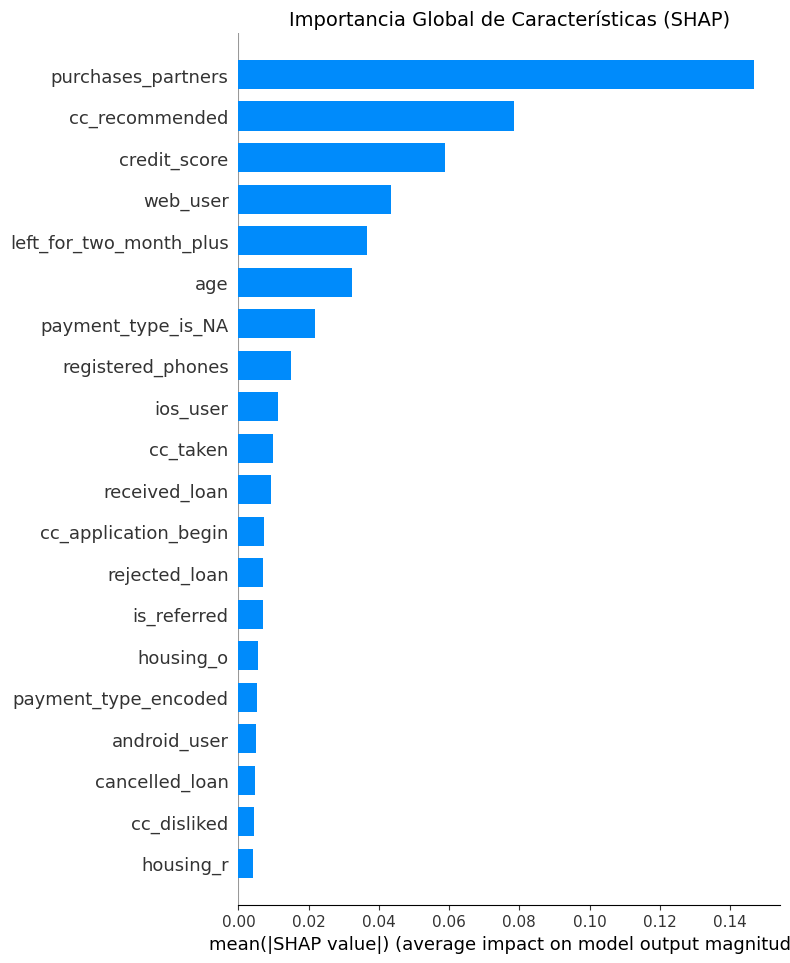

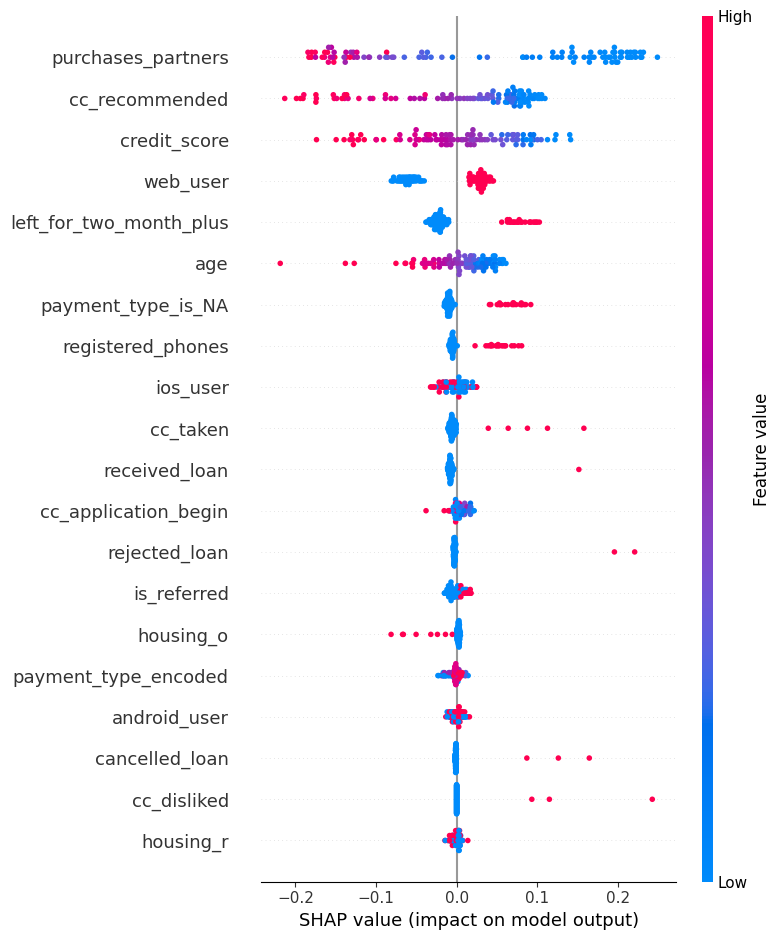


📊 Generando Dependence Plot para la característica más importante: 'purchases_partners'


<Figure size 800x600 with 0 Axes>

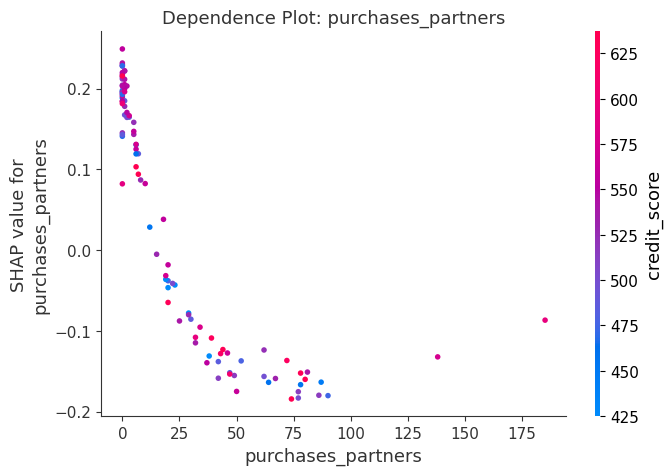


✨ Visualizaciones SHAP generadas.


In [ ]:
X_sample = X_train_best_synthetic.sample(n=1000, random_state=42)

def f(X):
    return model_for_shap.predict_proba(X)[:, 1]

explainer = shap.Explainer(f, X_sample)

X_test_sample_for_shap = X_test_real.sample(n=100, random_state=42)

print(f"⚙️ Calculando valores SHAP para una muestra del conjunto de prueba REAL...")
shap_values = explainer(X_test_sample_for_shap)

print("✅ Cálculo de valores SHAP completado.")

print("\n📊 Generando gráficos SHAP...")

# Summary Plot (Barra): Muestra la importancia global
plt.figure(figsize=(10, 6))
# Usamos shap_values.values ya que el objeto shap_values es una 'Explanation'
shap.summary_plot(shap_values, X_test_sample_for_shap, plot_type="bar", show=False)
plt.title("Importancia Global de Características (SHAP)", fontsize=14)
plt.show()

# Summary Plot (Beeswarm): Muestra el impacto y la dirección de cada característica
plt.figure(figsize=(10, 8))
# Usamos el objeto Explanation 'shap_values' directamente.
shap.summary_plot(shap_values, X_test_sample_for_shap)
plt.show()

# Dependence Plot: Selección robusta de la característica
try:
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

    # Encontrar el índice de la característica con mayor importancia
    most_important_feature_index = np.argmax(mean_abs_shap)
    feature_name = X_test_sample_for_shap.columns[most_important_feature_index]


    print(f"\n📊 Generando Dependence Plot para la característica más importante: '{feature_name}'")
    plt.figure(figsize=(8, 6))

    # El dependence_plot ahora recibe el array de valores SHAP unidimensional.
    shap.dependence_plot(
        feature_name,
        shap_values.values, # Valores SHAP para la clase 1
        X_test_sample_for_shap,
        title=f"Dependence Plot: {feature_name}"
    )
    plt.show()

except Exception as e:
    print(f"\n❌ No se pudo generar el Dependence Plot automáticamente. Error: {e}")

print("\n✨ Visualizaciones SHAP generadas.")

In [ ]:
best_ks_key = max(coherence_scores, key=lambda k: float(coherence_scores[k]))

df_best_ks = synthetic_datasets[best_ks_key].copy()

output_filename_ks = f"{best_ks_key}.parquet"

df_best_ks.to_parquet(output_filename_ks, index=False)

In [ ]:
best_synthetic_key = results_df.index[1]

df_best_synthetic = synthetic_datasets[best_synthetic_key].copy()

output_filename = f"{best_synthetic_key}.parquet"

df_best_synthetic.to_parquet(output_filename, index=False)

print(f"✅ Dataset '{best_synthetic_key}' guardado como '{output_filename}'")